# Jost function method I: bound state

The Jost function method will be introduced on the third day, which means that you will start implementing it without really knowing how it works. However, you already have all the tools to do it and understand the general idea.

In short, given the momentum $k$ of any type of state (bound, scattering, resonant), it is a method to obtain the wave function using properties of the Jost functions. This is achieved by replacing the Schrödinger equation (2nd order ODE) by two first order ODEs for the "pseudo-Jost functions".

## Basic setup

In [1]:
# Download and install library helpers
!gdown --id 1sZT60tdWLtmBCFKzs870UhiMurVdSPRk
!unzip -o lib.zip

# Set up pretty 
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

zsh:1: command not found: gdown
unzip:  cannot find or open lib.zip, lib.zip.zip or lib.zip.ZIP.


/var/folders/ld/0k7b046s3t7dpld1w1b2n_zw0000gn/T/ipykernel_22011/4058438398.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


## Riccati recursion

To use the Jost function method to obtain the radial wave functions of bound, scattering, and resonance states, we will need to do an analytical continuation of the spherical Bessel functions introduced in the lecture notes.

Of course, libraries already exist, but it is instructive to know how it can be done (at least one way). Here, the idea is to use a recursion formula from the NIST handbook (10.51(i)) which gives the spherical Bessel functions at any order from the functions at the lowest orders, and the fact that the closed forms of the lowest orders are simple and can be analytically continued into the complex plane without any special care for $z \neq 0$.

The recursion formula is given by:

\begin{equation}
f_{n+1}(z) = \frac{2n+1}{z} f_{n}(z) - f_{n-1}(z)
\end{equation}

This formula is actually not just for the spherical Bessel functions, so we will name the corresponding function accordingly.

**- Implement the function using the recursion formula**

In [2]:
def ji_or_yi_or_h1_or_h2_recursion (n, z, f0, f1):
    fi = 0.0
    for i in range (2, n):
        fi = (2.0*i-1.0)/z*f1 - f0

        f0 = f1
        f1 = fi

    return fi

Here, $n$ is the order, $z$ the argument, and $f_{0,1}$ are the values of the function in $z$ at the order 0 and 1 respectivelly. Tips: replace $n+1$ in the formula by $i$ in the code, so that $2n+1 = 2(i-1)+1 = 2i-1$. This is convenient to have $f_0$ on the right side of the formula at the first order. This will be, of course, a naive implementation and visible numerical differences will appear when compared against a library for $n > 6$.

Then, the next step is to implement the actual spherical Bessel functions using the generic recursion formula above. We know that:

\begin{align}
& j_0(z) = \frac{\sin(z)}{z} \\
& j_1(z) = \frac{\sin(z)}{z^2} - \frac{\cos(z)}{z}
\end{align}
and:

\begin{align}
& y_0(z) = -\frac{\cos(z)}{z} \\
& y_1(z) = -\frac{\cos(z)}{z^2} - \frac{\sin(z)}{z}
\end{align}

**- Implement the functions using the previous one**

In [3]:
import cmath

def jn (l, z):
    if z == 0.0:
        return 0
        print("jn: z must be nonzero")
        exit()

    f0 = cmath.sin(z)/z
    if l == 0:
        return f0

    f1 = cmath.sin(z)/(z*z) - cmath.cos(z)/z
    if l == 1:
        return f1

    return ji_or_yi_or_h1_or_h2_recursion(l, z, f0, f1)


def yn (l, z):
    if z == 0.0:
        return 0
        print("yn: z must be nonzero")
        exit()

    f0 = - cmath.cos(z)/z
    if l == 0:
        return f0

    f1 = - cmath.cos(z)/(z*z) - cmath.sin(z)/z
    if l == 1:
        return f1

    return ji_or_yi_or_h1_or_h2_recursion(l, z, f0, f1)

In addition, we can also define the incoming (-) and outgoing (+) Hankel functions in the special case where there is no Coulomb potential ($\eta=0$):

\begin{equation}
H_{l}^\pm(z) = z [ y_l(z) \pm i j_l(z) ]
\end{equation}

In [4]:
def Hp_Hm (sign, l, z):
    return z*(yn(l,z)+sign*1.0j*jn(l,z))

**- Check the validity of what you implemented using the following python library**

In [5]:
import scipy.special as sp
l=0
kr=1.0
jl = sp.spherical_jn(l,kr)
yl = sp.spherical_yn(l,kr)

# Potential

To solve a real nuclear physics case, we can also define a Woods-Saxon potential as follows:

\begin{equation}
V(r) = - V_0 f(r) - 4 \vec{l}.\vec{s} V_{so} \frac{1}{r} \frac{df(r)}{dr}
\end{equation}
with:

\begin{equation}
f(r) = - \frac{1}{ 1 + e^{\frac{r-R_0}{d}} }
\end{equation}

We can also use the fact that (show it):

\begin{equation}
2 \vec{l}.\vec{s} = j(j+1) - l(l+1) - \frac{3}{4}
\end{equation}

In [6]:
def pot_WS(r):

    d = 0.618
    R0 = 2.162
    Vo = 41.77
    Vso = 6.991

    exp_r_minus_R0_over_d = np.exp ((r - R0)/d)
    f = -1.0/(1.0 + exp_r_minus_R0_over_d)
    Vnuclear = Vo * f;

    df = exp_r_minus_R0_over_d*f*f/d
    two_l_scalar_s = j*(j+1) - l*(l+1) - 0.75

    Vspin_orbit = 0.0
    if ((two_l_scalar_s != 0) and (Vso != 0.0) and r != 0.0):
        Vspin_orbit = -2.0*two_l_scalar_s*Vso*df/r

    return Vnuclear + Vspin_orbit;

# Wave function

Now, we can implement the Jost function method naively, at first, and then improve it. We recall that the wave function can be obtained from the Jost functions as ($\eta=0$ here):

\begin{equation}
u_l(r,k) = \frac{i}{2} \left( F_{l,\eta}^+(k,r) H_{l,\eta}^-(k,r) - F_{l,\eta}^-(k,r) H_{l,\eta}^+(k,r) \right)
\end{equation}

**- Implement a function to return the wave function given the values of $k$, $r$, and $F^\pm(r)$**

In [7]:
def wf_u (k, r, Fp, Fm, l):
    if (r == 0.0): 
        return 0.0

    return 1.0j*0.5*(Fp*Hp_Hm(-1.0,l, k*r) - Fm*Hp_Hm(+1.0,l, k*r))

# Derivatives of the Jost functions

The critical point is then to calculate the derivatives of the Jost functions using the formula:

\begin{equation}
\frac{\partial}{\partial r}F_{l,\eta}^\pm(k,r) = \pm\frac{1}{ik} \frac{2m}{\hbar^2} V(r)(\mp i) H_{l,\eta}^\pm(k,r) u_{l}(r,k)
\end{equation}

**- Using the WS potential and the wave function, implement the derivative of the Jost functions and return [dFp,dFm]**

In [8]:
def dF(F, r, k, two_amu_over_hbar2):
    Fp = F[0]
    Fm = F[1]

    u = wf_u(k,r,Fp,Fm, l)

    dFp = 0.0
    dFm = 0.0

    if r==0.0:
        return [0.0,0.0]

    Hp = Hp_Hm (+1.0,l, k*r)
    Hm = Hp_Hm (-1.0,l, k*r)
    dFp = +(1.0/(1.0j*k))*two_amu_over_hbar2*pot_WS(r)*(-1.0j*Hp)*u
    dFm = -(1.0/(1.0j*k))*two_amu_over_hbar2*pot_WS(r)*(+1.0j*Hm)*u

    return [dFp,dFm]

# Numerical integration

We are now almost ready to solve the Schrödinger equation and obtain the wave function by integrating the ODEs for the Jost functions. Due to the way the standard ODE solver used in the example presented before (simple 2nd order ODE) is implemented, it cannot immediately handle complex numbers and pass arguments trivially. To use it, we would need to implement an interface, but this would be a little convoluted for this exercise, even though it is fairly standard. We will thus use a different package.

In the following function, we initialize the Jost functions as they should, and then solve the ODEs using the derivatives defined above. Then, we extract the Jost functions obtained and calculate the wave function.

We remind that the Jost function in zero must equal 1, or `1.0+0.0j` to avoid issues with the ODE solver.

**- Implement the function to calculate the wave function by solving the ODEs for the Jost functions first**

In [9]:
!pip3 install odeintw

from odeintw import odeintw

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [10]:
def integrate_wf (r_range, k, l, two_amu_over_hbar2):

    u_range=np.array([])
    pot_range = np.array([])

    # initial values of the r-dependent Jost function at r=0
    # they must be declared as complex (even if real) for the ODE solver
    #
    Fp0 = 1.0+0.0j
    Fm0 = 1.0+0.0j
    F0 = np.array([Fp0, Fm0])

    F = odeintw(dF,F0,r_range, args=(k, two_amu_over_hbar2,))

    # extract the outgoing and incoming r-dependent Jost functions
    Fp_range = np.array([F[i][0] for i in range(Nr)])
    Fm_range = np.array([F[i][1] for i in range(Nr)])


    # compute the wave function using the Jost functions obtained
    for i in range(Nr):
        Fp = Fp_range[i]
        Fm = Fm_range[i]
        r = r_range[i]
        u = wf_u(k,r,Fp,Fm, l)
        u_range = np.append(u_range, u)

        pot_range = np.append(pot_range, pot_WS(r))

    return u_range, pot_range, Fp_range, Fm_range


and we run the program for a given value of the momentum corresponding to a bound state (given here, but how could you obtain it?):

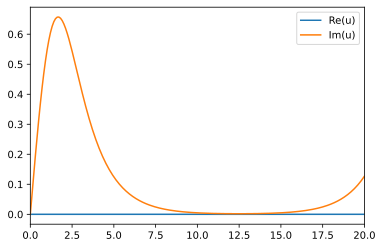

In [11]:
import numpy as np

two_amu_over_hbar2 = 0.038540695 # MeV^-1 fm^-2
l=0
j=0.5
k=0.6569928182*1.0j # fm^-1, bound state for the potential considered

# radial discretization (in fm)
ri = 0.0
rf = 20.0
Nr = 200
r_range = np.linspace(ri,rf,Nr)
r_step = (ri-rf)/Nr

u_range, pot_range, Fp_range, Fm_range = integrate_wf (r_range, k, l, two_amu_over_hbar2)


import matplotlib.pyplot as plt
plt.xlim(0.0,20.0)
plt.plot(r_range, (np.array(u_range)).real,'-', label='Re(u)')
plt.plot(r_range, (np.array(u_range)).imag,'-', label='Im(u)')

plt.legend(loc='upper right', fontsize=10)
plt.show()

# Check against a benchmark solution

In [12]:
!gdown --id 1d5-xUt5Yo3IXD9m2YOMKLzxa8PZy4xDN

zsh:1: command not found: gdown


We can see that something weird is happening beyond $r = 15$ fm. To check, we plot the benchmark solution provided in an external file.

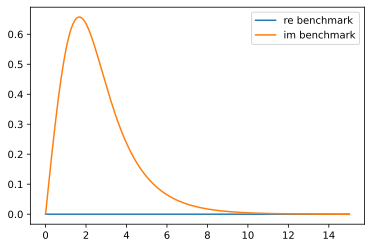

In [13]:
def get_data_u(file_name):

    arr_r=[]
    arr_u_re=[]
    arr_u_im=[]
    for line in open (file_name):
        if line[0] != "#":
            values = line.strip ("\n").split ()

            arr_r.append (float(values[0]))
            arr_u_re.append (float (values[1]))
            arr_u_im.append (float (values[2]))

    return arr_r, arr_u_re, arr_u_im


mksize=1.2
arr_r_bench, arr_u_re_bench, arr_u_im_bench = get_data_u("benchmark_wf_bound")
plt.plot(arr_r_bench, arr_u_re_bench, linestyle="-", marker="", markersize=mksize, label="re benchmark")
plt.plot(arr_r_bench, arr_u_im_bench, linestyle="-", marker="", markersize=mksize, label="im benchmark")

plt.legend(loc='upper right', fontsize=10)
plt.show()

Clearly, the present code gives a correct result but has some divergence issue at large distances. Can you find what happened? How could you solve the problem?